In [28]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import random
import torch
import bayesflow as bf
import matplotlib.pyplot as plt
import pandas as pd

from data_utils import DataGenerator, variable_n, sample_model_0, sample_model_1
from networks import EvidenceNetwork
from evaluation import test_model_batch
from metrics import logk_accuracy, k_accuracy
from losses import *

In [16]:
print(f"Using Keras backend: {keras.backend.backend()}")

print("CUDA available:", torch.cuda.is_available())
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

np.random.seed(17)
random.seed(17)
torch.manual_seed(17)

Using Keras backend: torch
CUDA available: True
GPU device: NVIDIA GeForce RTX 3070


### Wrapper

In [ ]:
def train_test(model, name, threshold, train_loader, val_loader, n_tests, epochs):
    
    print(f"\n--- Training: {name} ---")
    
    # train
    with torch.enable_grad():
        history = model.fit(
            train_loader, validation_data=val_loader, epochs=epochs, verbose=1
        )
    
    # test

    print(f"\n--- Testing: {name} ---")

    test_results = {}
    for n_test in n_tests:

        acc_0, acc_1 = test_model_batch(
            model, sample_model_0, sample_model_1, 
            threshold=threshold, 
            n=n_test, 
            n_norm_factor=train_loader.n_norm, 
            pr=False
        )

        print(f'n: {n_test}')
        print(f" Model 0 accuracy: {acc_0*100:.2f}%")
        print(f" Model 1 accuracy: {acc_1*100:.2f}%")

        test_results[f'n_{n_test}'] = {'acc_0': acc_0, 'acc_1': acc_1}
        
    return model, history, test_results

# Results

In [49]:
BATCH_SIZE = 128
TRAIN_BATCHES = 256
VAL_BATCHES = 8
EPOCHS = 8
N_NORM_FACTOR = 30
N_TESTS = [10, 25]

train_loader = DataGenerator(
    batches_per_epoch=TRAIN_BATCHES, n_generator=variable_n, 
    batch_size=BATCH_SIZE, n_norm=N_NORM_FACTOR
)
val_loader = DataGenerator(
    batches_per_epoch=VAL_BATCHES, n_generator=variable_n, 
    batch_size=BATCH_SIZE, n_norm=N_NORM_FACTOR
)

loss_configs = [
    {'name': 'Logistic', 'loss': logistic_loss, 'output_type': 'log(K)', 'metric': logk_accuracy, 'threshold': 0.0},
    {'name': 'Cross Entropy', 'loss': cross_entropy_loss, 'output_type': 'p', 'metric': 'accuracy', 'threshold': 0.5},
    {'name': 'Exponential', 'loss': exponential_loss, 'output_type': 'log(K)', 'metric': logk_accuracy, 'threshold': 0.0},
    {'name': 'Alpha-Exponential', 'loss': alpha_exponential_loss, 'output_type': 'log(K)', 'metric': logk_accuracy, 'threshold': 0.0},
    {'name': 'Alpha-Log-Exponential', 'loss': alpha_log_exponential_loss, 'output_type': 'K', 'metric': k_accuracy, 'threshold': 1.0},
    {'name': 'lPOP', 'loss': lpop_exponential_loss, 'output_type': 'log(K)', 'metric': logk_accuracy, 'threshold': 0.0},
]

In [50]:
all_models = {}
all_histories = {}
all_test_results = {}

for config in loss_configs:
    # create model
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4, decay_steps=EPOCHS * len(train_loader)
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model_instance = EvidenceNetwork(config['output_type'])
    
    model_instance.compile(
        optimizer=optimizer,
        loss=config['loss'],
        metrics=[config['metric']]
    )
    
    # train + test
    trained_model, history, test_results = train_test(
        model=model_instance,
        name=config['name'],
        threshold=config['threshold'],
        train_loader=train_loader,
        val_loader=val_loader,
        n_tests=N_TESTS,
        epochs=EPOCHS
    )
    
    all_models[config['name']] = trained_model
    all_histories[config['name']] = history
    all_test_results[config['name']] = test_results


--- Training: Logistic ---
Epoch 1/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - logk_accuracy: 0.8107 - loss: 0.4195 - val_logk_accuracy: 0.8154 - val_loss: 0.4048
Epoch 2/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.8244 - loss: 0.3915 - val_logk_accuracy: 0.8242 - val_loss: 0.3906
Epoch 3/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - logk_accuracy: 0.8212 - loss: 0.3960 - val_logk_accuracy: 0.8184 - val_loss: 0.4166
Epoch 4/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - logk_accuracy: 0.8251 - loss: 0.3890 - val_logk_accuracy: 0.8057 - val_loss: 0.4198
Epoch 5/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - logk_accuracy: 0.8220 - loss: 0.3929 - val_logk_accuracy: 0.8496 - val_loss: 0.3529
Epoch 6/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - logk_accuracy: 0.8203 - loss: 0.3962 - val_logk_accuracy: 0.8164 - val_loss: 0.3930
Epoch 7/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - logk_accuracy: 0.8246 - loss: 0.3879 - val_logk_accuracy: 0.8145 - val_loss: 0.3971
Epoch 

In [51]:
summary_data = []
for name, results in all_test_results.items():
    row = {'Loss Function': name}

    for n in N_TESTS:
        row[f'Acc M0 (n={n})'] = results[f'n_{n}']['acc_0']
        row[f'Acc M1 (n={n})'] = results[f'n_{n}']['acc_1']
        
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

accuracy_cols = []
for i in N_TESTS:
    accuracy_cols.append(f'Acc M0 (n={i})')
    accuracy_cols.append(f'Acc M1 (n={i})')

for col in accuracy_cols:
    summary_df[col] = summary_df[col] * 100

summary_df.set_index('Loss Function', inplace=True)
display(summary_df.style.format("{:.2f}%"))

,Acc M0 (n=10),Acc M1 (n=10),Acc M0 (n=25),Acc M1 (n=25)
Loss Function,,,,
Logistic,76.00%,69.80%,95.80%,71.60%
Cross Entropy,74.00%,70.60%,95.60%,71.20%
Exponential,79.00%,72.00%,93.40%,72.80%
Alpha-Exponential,73.60%,77.00%,92.40%,72.60%
Alpha-Log-Exponential,66.60%,72.00%,94.80%,72.60%
lPOP,77.40%,74.20%,92.40%,71.20%



--- Individual Loss Plots ---

Loss History for: Logistic


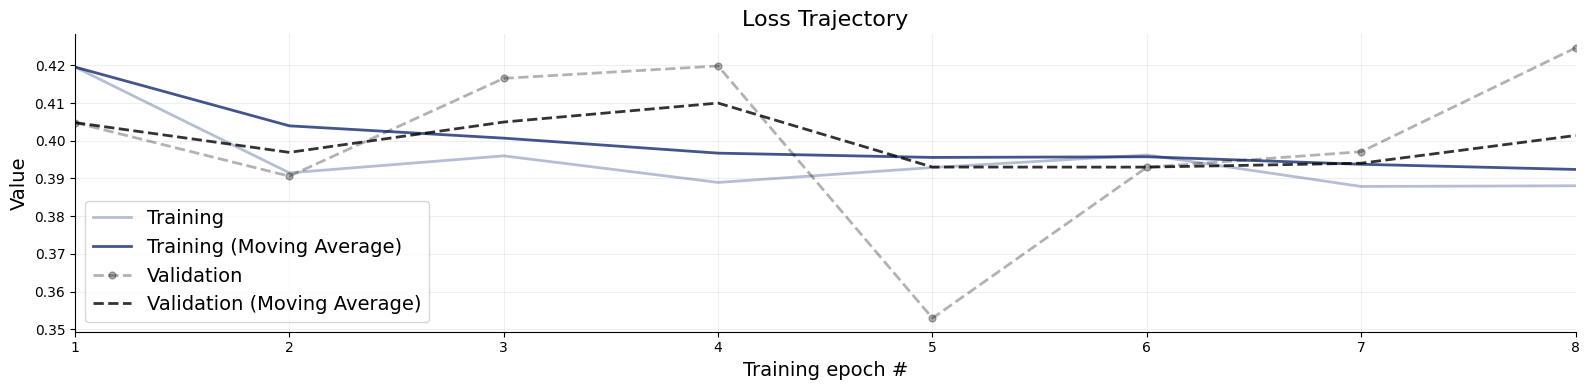


Loss History for: Cross Entropy


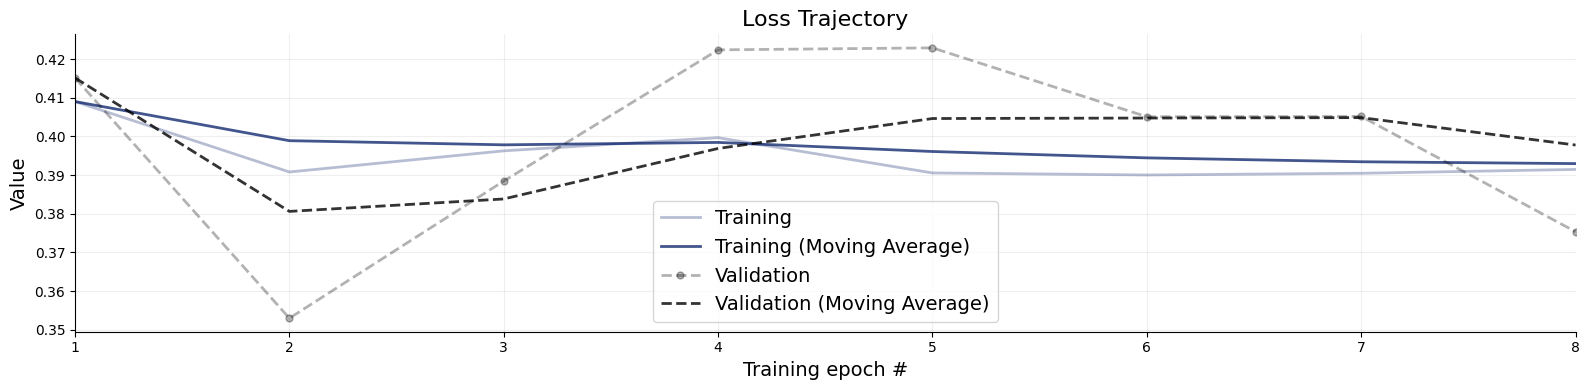


Loss History for: Exponential


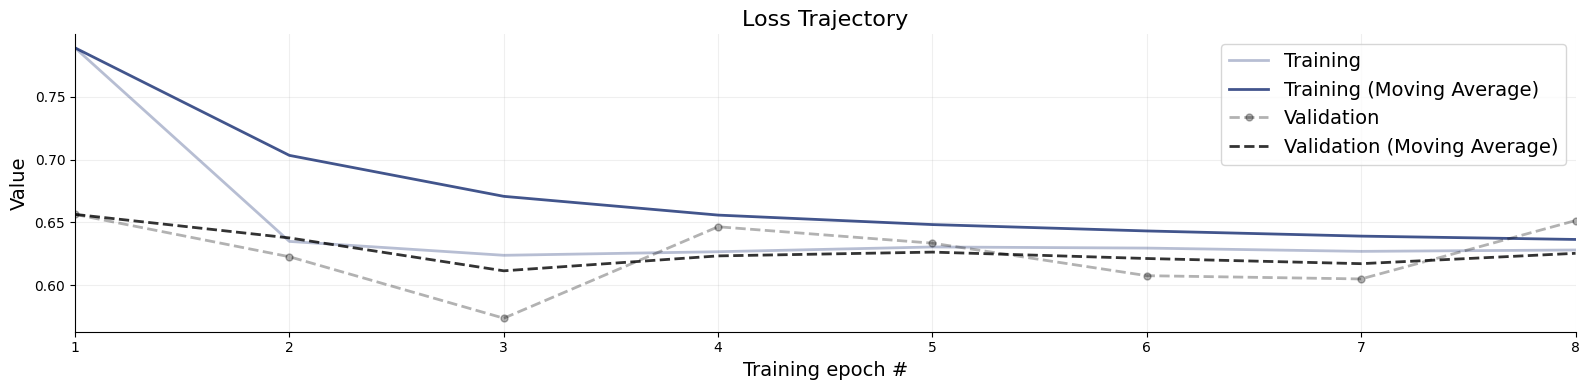


Loss History for: Alpha-Exponential


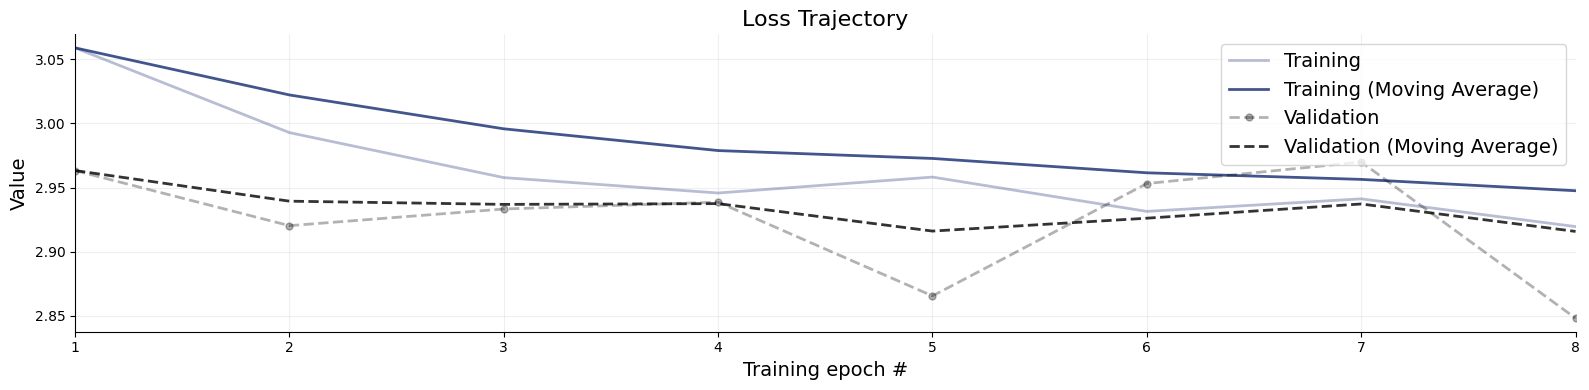


Loss History for: Alpha-Log-Exponential


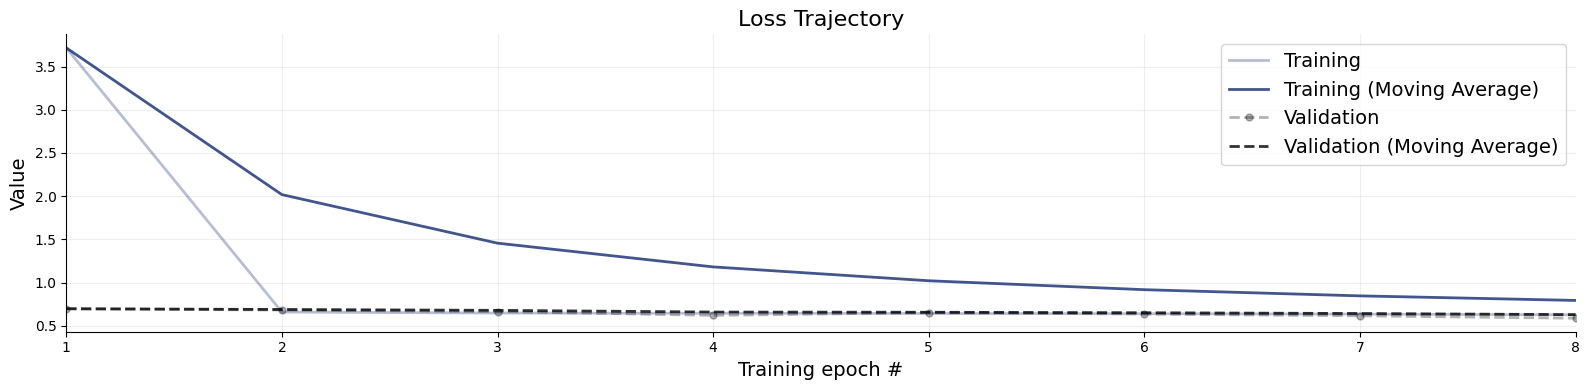


Loss History for: lPOP


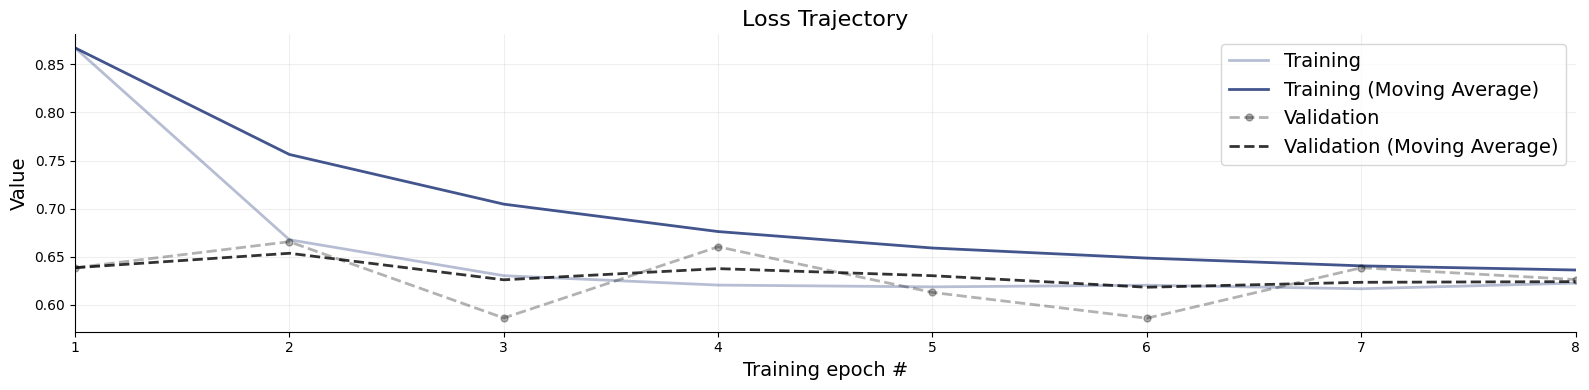

In [52]:
print("\n--- Individual Loss Plots ---")
for name, history in all_histories.items():
    print(f"\nLoss History for: {name}")
    bf.diagnostics.plots.loss(history=history)
    plt.show()